In [6]:
import yerbamate, pandas as pd, os
env = yerbamate.Environment()

hashtags_path = os.path.join(env["plots"], "analysis", "hashtag.parquet")

df = pd.read_parquet(hashtags_path)
df.head()

year  month  day          hashtag  count
0  2022     12   31       مهسا_امینی  79665
1  2022     12   31  اعتصابات_سراسری  14601
2  2022     12   31   IranRevolution  14416
3  2022     12   31       MahsaAmini  13174
4  2022     12   31          جوانرود   9816

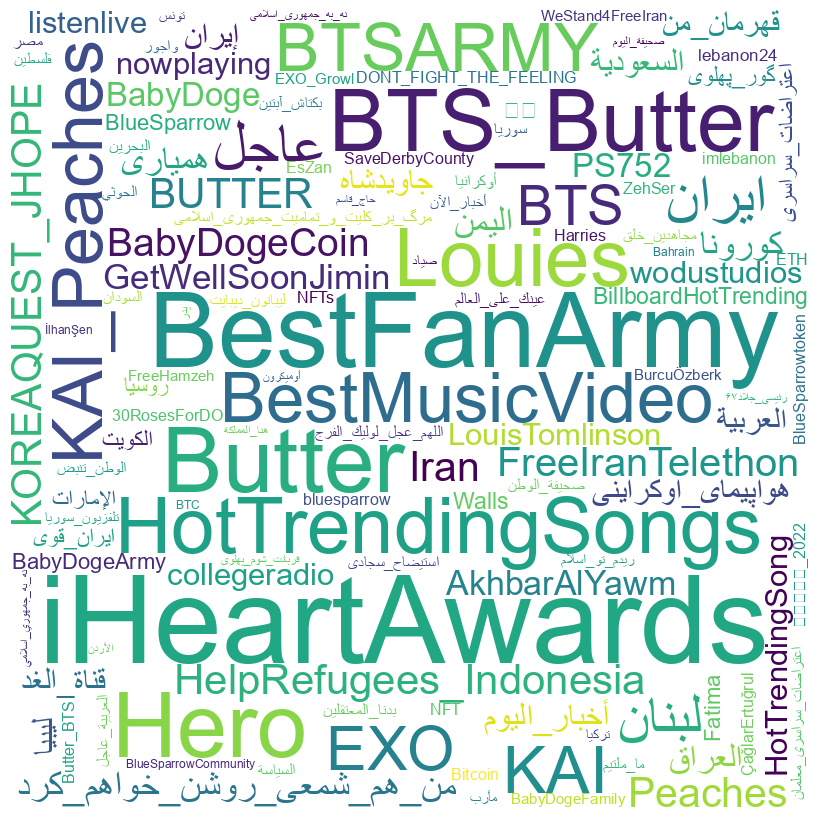

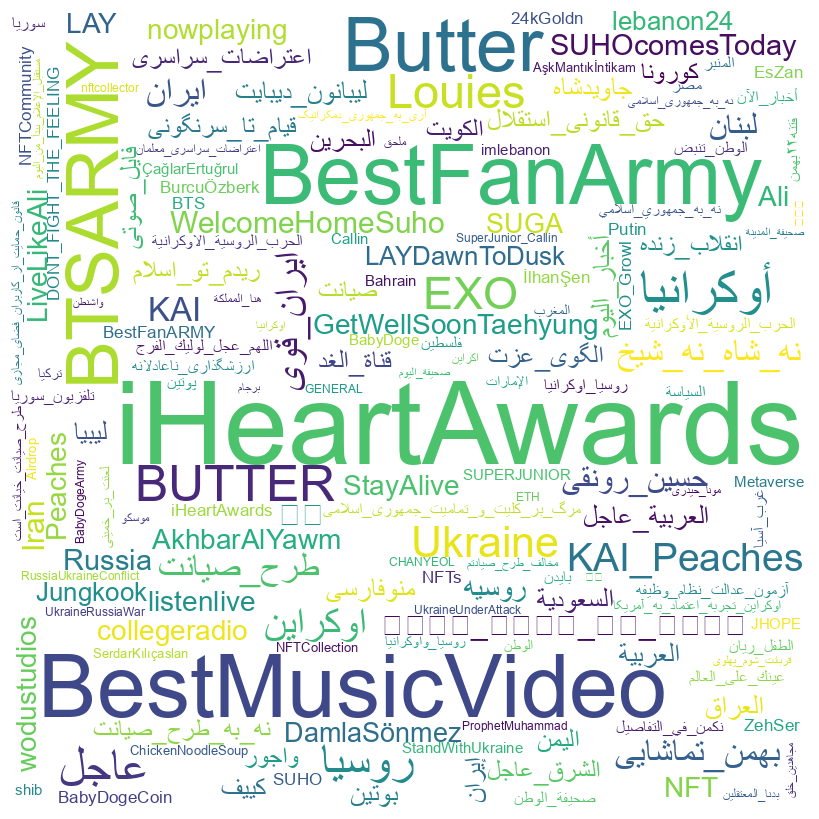

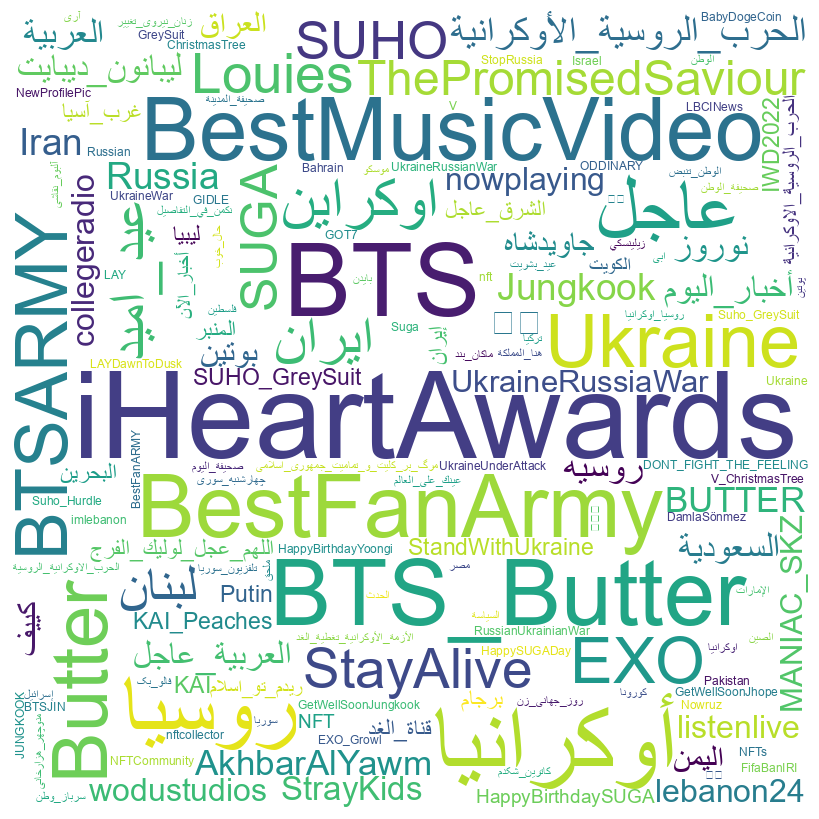

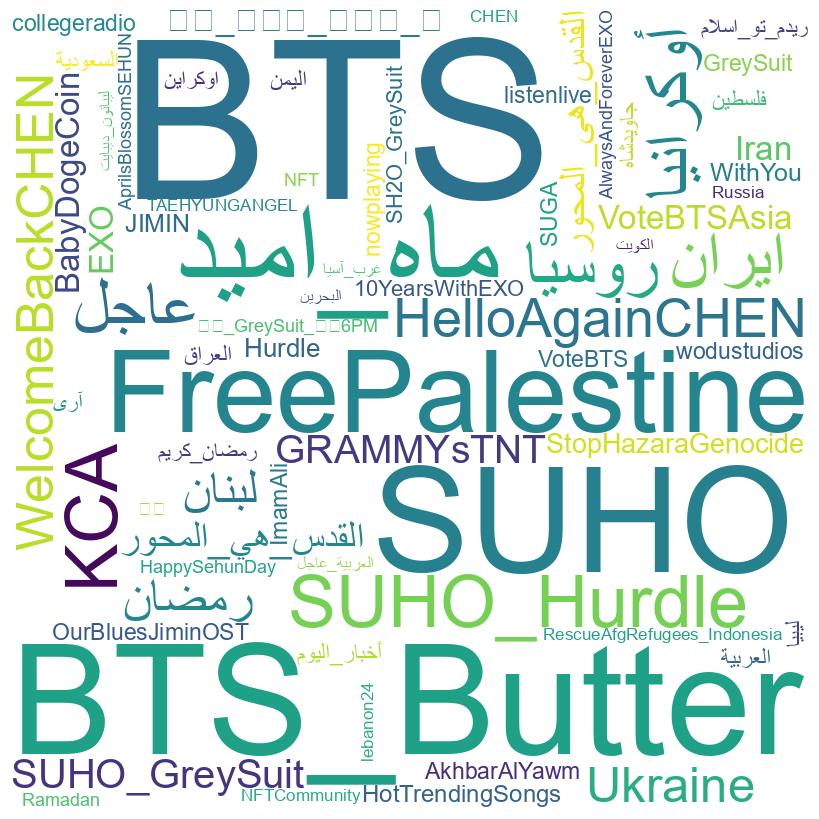

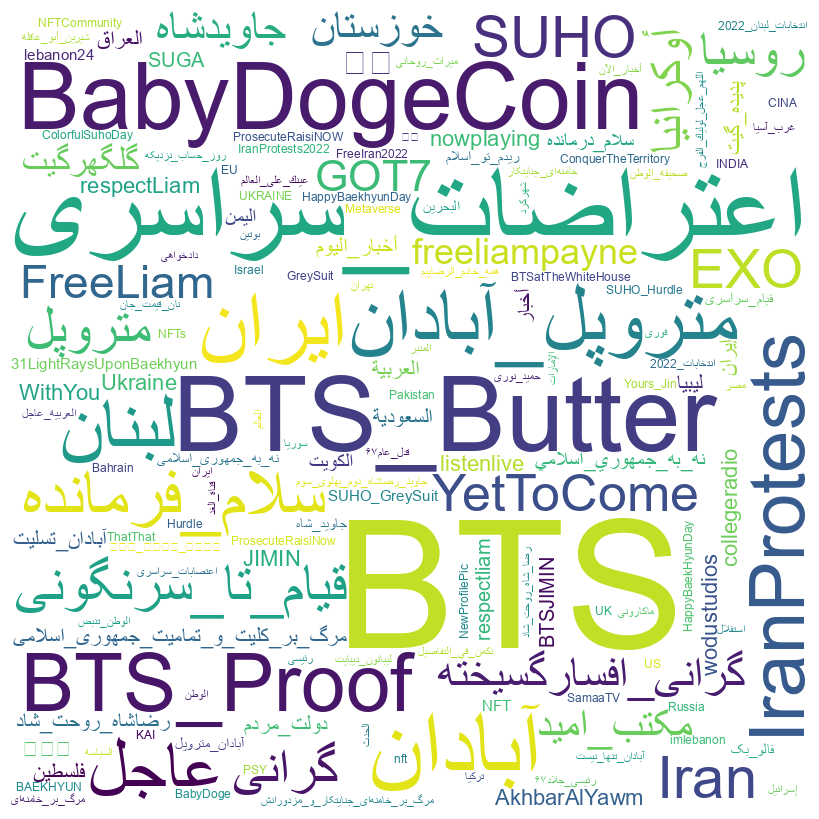

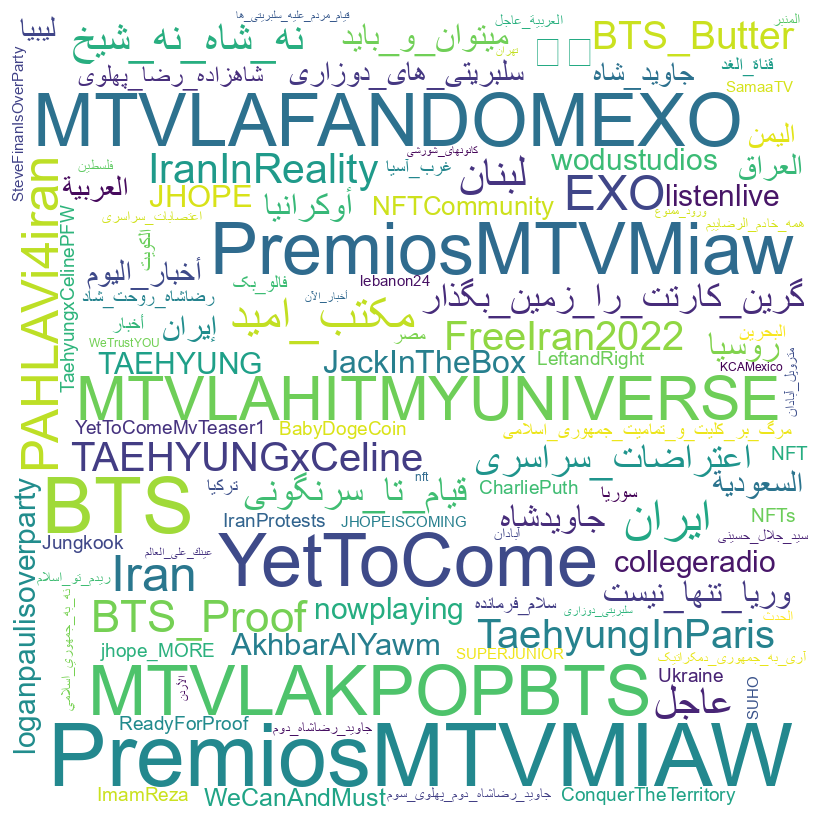

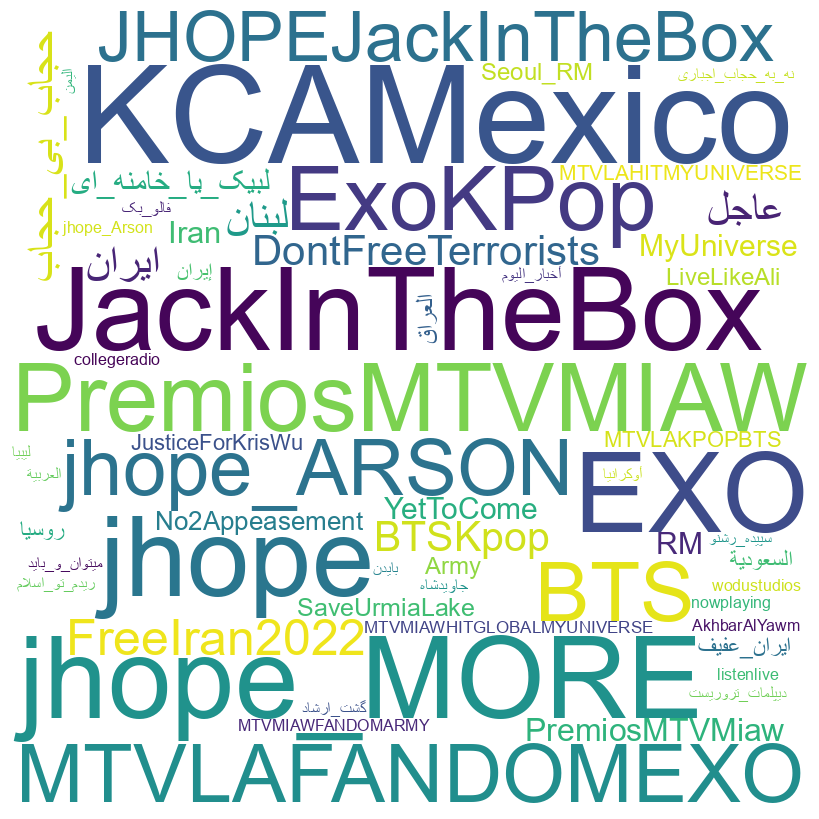

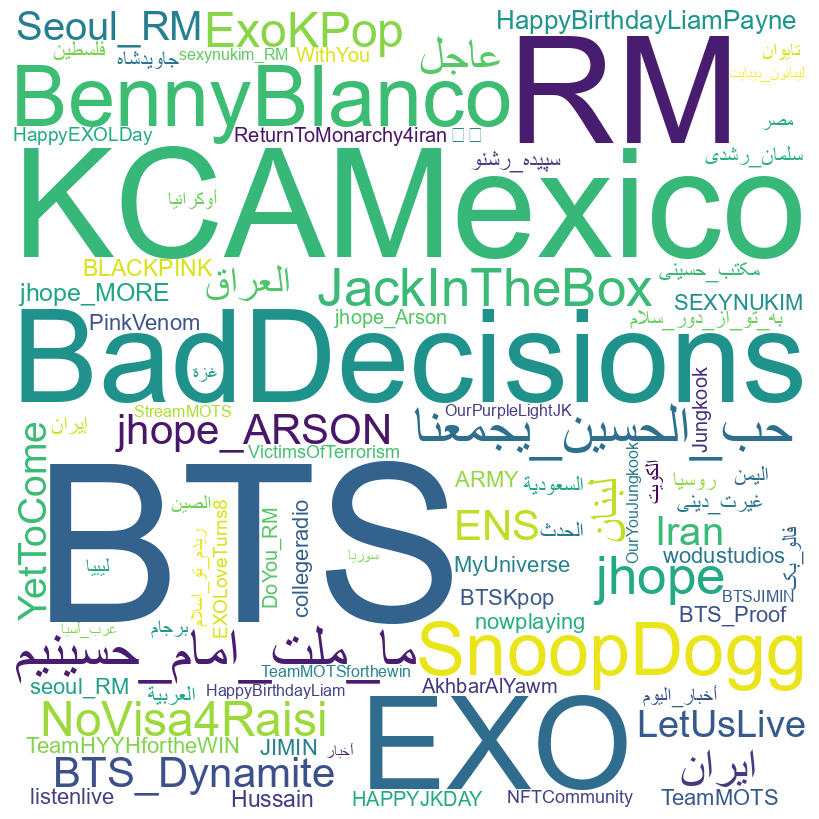

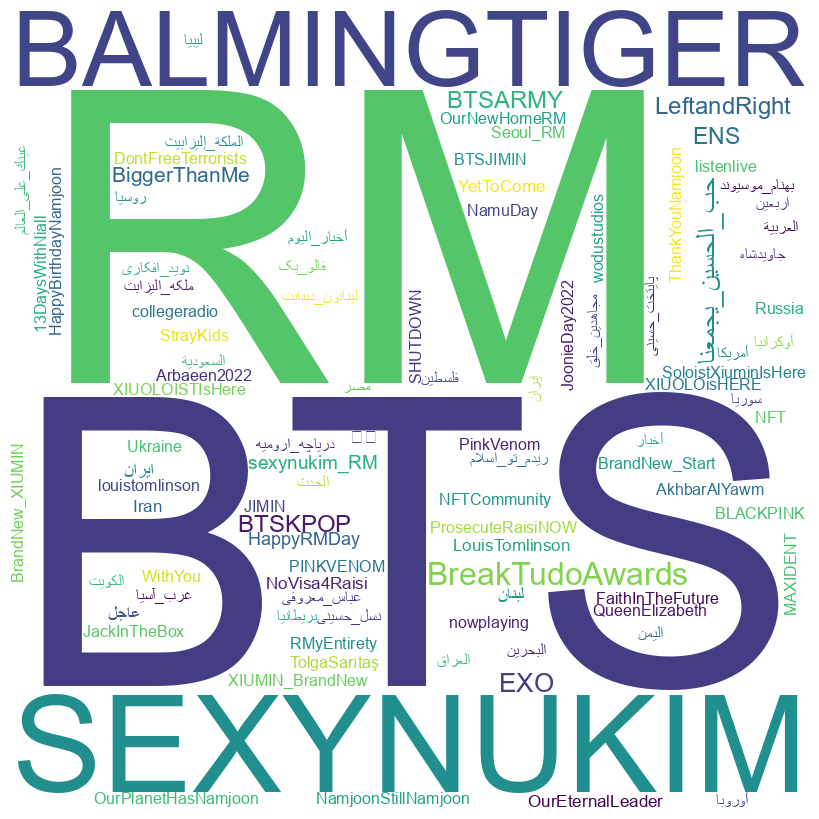

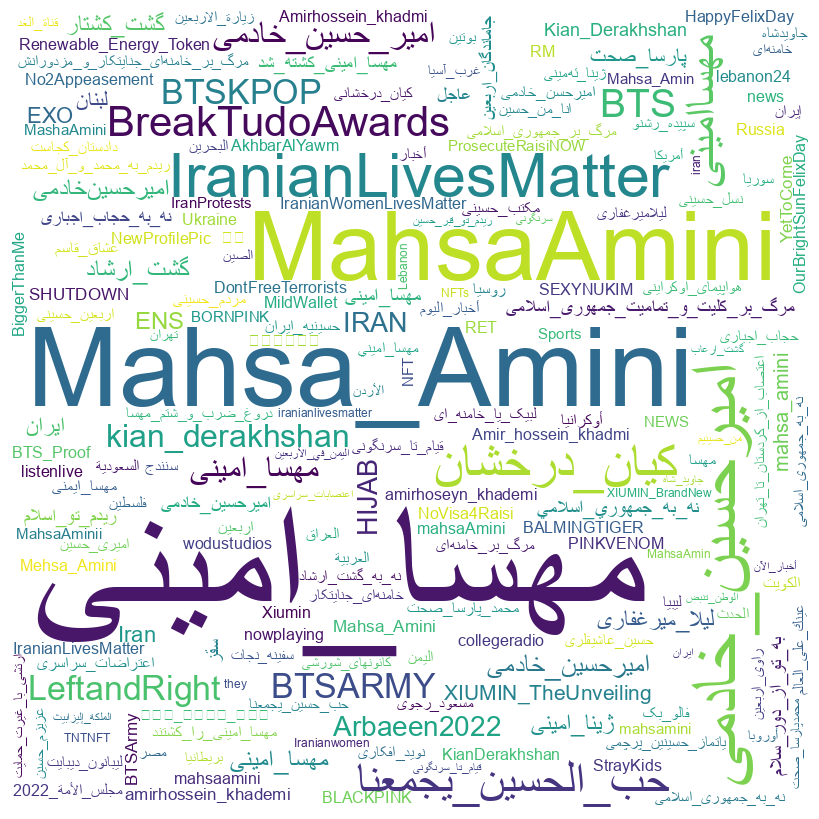

In [21]:
# font_path ='/usr/share/fonts/TTF/XB-Zar-Regular.ttf'

font_path = "/home/al/Downloads/arial-cufonfonts/ARIAL.TTF"
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Convert year, month, and day columns to datetime
df["date"] = pd.to_datetime(df[["year", "month", "day"]])

# Split the dataframe into two based on the date
df_before = df[df["date"] < "2022-09-14"]
df_after = df[df["date"] >= "2022-09-14"]

# for after go to maximum 2023-04-16
df_after = df_after[df_after["date"] < "2023-04-16"]

# Group by month for the period before
df_before_grouped = (
    df_before.groupby(
        [
            df_before["date"].dt.year.rename("year"),
            df_before["date"].dt.month.rename("month"),
            "hashtag",
        ]
    )["count"]
    .sum()
    .reset_index()
)

# Group by week for the period after
df_after_grouped = (
    df_after.groupby([df_after["date"].dt.to_period("W").rename("week"), "hashtag"])[
        "count"
    ]
    .sum()
    .reset_index()
)


# Function to generate and plot word cloud
def generate_word_cloud(df_grouped, time_period):
    # df = df_grouped.groupby(["hashtag", time_period]).sum().reset_index()

    for date, df in df_grouped.groupby(time_period):
        # only top 200 hashtags
        df = df.sort_values(by="count", ascending=False).head(200)
        # text = ''.join(' '.join([hashtag]*count) for hashtag, count in zip(df["hashtag"], df["count"]))
        # print(text)
        wordcloud = WordCloud(
            font_path,
            width=800,
            height=800,
            background_color="white",
            stopwords=None,
            include_numbers=True,
            collocations=False,
            min_font_size=12,
        ).generate_from_frequencies(df.set_index("hashtag")["count"].to_dict())

        # Plot the word clouds
        plt.figure(figsize=(8, 8), facecolor=None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)

        # find next date, if weekly or year month its motnly
        # Determine start and end date of each period
        if isinstance(date, tuple):
            # Monthly
            start_date = f"{date[0]}-{date[1]}-01"
            start_date = pd.to_datetime(start_date)
            end_date = start_date + pd.offsets.MonthEnd(1)
            # if start date is after 2022-09-01, then end date is 2022-09-14
            if start_date >= pd.to_datetime("2022-09-01"):
                end_date = pd.to_datetime("2022-09-14")
        else:
            # Weekly
            start_date = date.start_time.date()
            end_date = date.end_time.date()

        # format dates to have {year}-{month}-{day} format
        start_date = start_date.strftime("%Y-%m-%d")
        end_date = end_date.strftime("%Y-%m-%d")

        save_path = os.path.join(env["plots"], "analysis", "hashtag", "top_word_cloud")
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        plt.title(f"Top Hashtags WordCloud from {start_date} to {end_date}")
        plt.savefig(os.path.join(save_path, f"top_hashtags_wordcloud_{start_date}_{end_date}.png"))
        plt.show()


# Generate word clouds
generate_word_cloud(df_before_grouped, ["year", "month"])  # for monthly
generate_word_cloud(df_after_grouped, "week")  # for weekly

In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Convert year, month, and day columns to datetime
df["date"] = pd.to_datetime(df[["year", "month", "day"]])

# Split the dataframe into two based on the date
df_before = df[df["date"] < "2022-09-14"]
df_after = df[df["date"] >= "2022-09-14"]


# Group by month for the period before
df_before_grouped = df_before.groupby([df_before["date"].dt.year.rename("year"), df_before["date"].dt.month.rename("month"), "hashtag"])["count"].sum().reset_index()

# Group by week for the period after
df_after_grouped = df_after.groupby([df_after["date"].dt.to_period('W').rename("week"), "hashtag"])["count"].sum().reset_index()

df_before_grouped.head()

year  month              hashtag  count
0  2022      1             010byday      1
1  2022      1  0110_DONGMYEONG_DAY     13
2  2022      1               0120am      1
3  2022      1          0120baghdad      1
4  2022      1         0124_CyA_DAY     27

In [4]:
df = df_before_grouped.groupby(["year", "month"])
df = df.get_group((2022, 3))
len(df['hashtag'].unique())
print(len(df['hashtag'].unique()), len(df['hashtag']))

 

246863 246863


In [ ]:
import imageio
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import io

# We'll store each frame of the gif in this list
frames = []

df = df[df["date"] < "2023-04-26"]
# Sort the DataFrame by date
df = df.sort_values(by='date')


# For each date
for date, df_date in df.groupby('date'):

    # Get the hashtags and counts for this date
    hashtags = df_date['hashtag']
    counts = df_date['count']
    
    # Generate the word cloud text
    text = ' '.join(' '.join([hashtag]*count) for hashtag, count in zip(hashtags, counts))
    
    # Generate the word cloud
    wordcloud = WordCloud(font_path=font_path, width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = None, 
                    min_font_size = 16).generate(text)
    
    # Display the generated image with matplotlib, save to a bytes buffer
    date_fmt = date.strftime("%Y-%m-%d")
    plt.title(f"Top Hashtags WordCloud on {date_fmt}")

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
            
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    
    # Add this frame to the list of frames
    frames.append(imageio.imread(buf))

    # Clear the matplotlib plot so the next one doesn't overlap
    plt.clf()

# Save frames as a mp4
imageio.mimsave('wordcloud.mp4', frames, fps=1) # 10 fps for smooth transition


In [ ]:
imageio.mimsave('wordcloud.mp4', frames, fps=4) # 10 fps for smooth transition
